# 投资者情绪专题

## 1.数据准备

In [1]:
import sys
import os
import cudf  #CUDA计算
import pandas as pd

# 自行编写的包
sys.path.append('/home/ubuntu/notebook/Investor-Sentiment')
sys.path.append('/usr/local/stata17/utilities')
from loader.findata_loader import Loader
from utils.sql import DB

# Stata
from pystata import config  # noqa

config.init('mp')
# ------------------------------数据集路径----------------------------------#
DATASETS_PATH = '/data/DataSets/investor_sentiment/'


  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user 8-core , expiring  1 Jan 2025
Serial number: 501709301094
  Licensed to: Colin's Stata
               Love U

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000; see help set_maxvar.


In [2]:
def extract_pdate_wcsentiment():
    """
    提取推文中的情绪
    :return:
    """
    # 提取
    df_select = pd.read_sql(
            "SELECT id,p_date, title_neg, cover_neg, biz FROM WECAHT_DATA.articles_tag "
            "WHERE mov=10 AND biz in ('MjM5MzMwNjM0MA==','MjM5NzQ5MTkyMA==','MjY2NzgwMjU0MA==','MjY2NzgwMjU0MA==')",
            con=DB().ENGINE,
            parse_dates=["p_date"])

    # 筛选
    df_select['trade_date'] = df_select['p_date'].dt.strftime('%Y%m%d').astype('uint32')
    df_select = df_select.query("trade_date>=20140101")

    # 阈值处理
    df_select['title_flag'] = df_select['title_neg'].apply(lambda x: 1 if x > 0.5 else 0)
    df_select['cover_flag'] = df_select['cover_neg'].apply(lambda x: 1 if x > 0.5 else 0)

    # 每日情绪
    df_select['day_article'] = df_select.groupby('trade_date')['id'].transform('count')

    df_select['tex_neg'] = df_select['title_flag'] / df_select['day_article']
    df_select['img_neg'] = df_select['cover_flag'] / df_select['day_article']

    # 时间序列
    df_select = df_select.groupby(['trade_date', ], as_index=False).first()
    # 筛选
    return df_select[['trade_date', 'img_neg', 'tex_neg']].set_index('trade_date').sort_index().reset_index()


extract_pdate_wcsentiment()

/tmp/ipykernel_21931/1293121355.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select['title_flag'] = df_select['title_neg'].apply(lambda x: 1 if x > 0.5 else 0)
/tmp/ipykernel_21931/1293121355.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select['cover_flag'] = df_select['cover_neg'].apply(lambda x: 1 if x > 0.5 else 0)
/tmp/ipykernel_21931/1293121355.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

,trade_date,img_neg,tex_neg
0,20140101,0.0,0.000000
1,20140102,0.0,0.000000
2,20140103,0.0,0.333333
3,20140104,0.0,0.000000
4,20140105,0.0,0.000000
...,...,...,...
3069,20220623,0.0,0.000000
3070,20220624,0.0,0.142857
3071,20220625,0.0,0.000000
3072,20220626,0.0,0.000000


In [3]:
df_forum = (
        cudf.read_parquet(
                DATASETS_PATH + 'FORUM_SENT_TRANS.parquet',
                columns=['PostDate', 'Stockcode', 'PostSource', 'PositiveSentIndexA', 'PositiveSentIndexB', 'TotalPosts', 'AvgReadings',
                         'AvgComments', 'AvgPositThumbUps'])
        .query("PostDate>=20140101 ")

)

In [4]:
df_forum.set_index(['PostDate', 'Stockcode']).sort_index().to_pandas()

PostSource  PositiveSentIndexA  PositiveSentIndexB  \
PostDate Stockcode                                                       
20140101 000030.SZ           1                 NaN                 NaN   
         000030.SZ           1                 NaN                 NaN   
         000034.SZ           1                 NaN                 NaN   
         000034.SZ           1                 NaN                 NaN   
         000043.SZ           1                 NaN                 NaN   
...                        ...                 ...                 ...   
20211016 900948.SH           1                 NaN                 NaN   
         900952.SH           1                 NaN                 NaN   
         900953.SH           1                 NaN                 NaN   
         900955.SH           1                 NaN                 NaN   
         900957.SH           1                 NaN                 NaN   

                    TotalPosts  AvgReadings  AvgComments  AvgPositThumbUps  
PostDate Stockcode                                                          
20140101 000030.SZ           0          NaN          NaN               NaN  
         000030.SZ           0          NaN          NaN               NaN  
         000034.SZ           0          NaN          NaN               NaN  
         000034.SZ           0          NaN          NaN               NaN  
         000043.SZ           0          NaN          NaN               NaN  
...                        ...          ...          ...               ...  
20211016 900948.SH           0          NaN          NaN               NaN  
         900952.SH           0          NaN          NaN               NaN  
         900953.SH           0          NaN          NaN               NaN  
         900955.SH           0          NaN          NaN               NaN  
         900957.SH           0          NaN          NaN               NaN  

[11846133 rows x 7 columns]

## 2.投资者情绪指标计算

计算加权影响力,参数为影响力系数,点赞评论阅读

In [5]:
def cal_investor_sentiment(df: cudf.DataFrame, a, b, c, d) -> cudf.DataFrame:
    """
    计算加权投资者情绪
    :return:
    """

    # 每日总量
    df['DayTotalPosts'] = df.groupby(['PostDate', ])['TotalPosts'].transform('sum')
    df['DayAvgReadings'] = df.groupby(['PostDate', ])['AvgReadings'].transform('sum')
    df['DayAvgComments'] = df.groupby(['PostDate', ])['AvgComments'].transform('sum')
    df['DayAvgPositThumbUps'] = df.groupby(['PostDate', ])['AvgPositThumbUps'].transform('sum')

    # 加权因子总量
    df['DayTotalPostsFactor'] = df['TotalPosts'] / df['DayTotalPosts']
    df['DayAvgReadingsFactor'] = df['AvgReadings'] / df['DayAvgReadings']
    df['DayAvgCommentsFactor'] = df['AvgComments'] / df['DayAvgComments']
    df['DayAvgPositThumbUpsFactor'] = df['AvgPositThumbUps'] / df['DayAvgPositThumbUps']

    # 个股加权情绪因子
    df['PositiveSentIndexAFactor'] = (
            (df['DayTotalPostsFactor'] * a + df['DayAvgReadingsFactor'] * b +
             df['DayAvgCommentsFactor'] * c + df['DayAvgPositThumbUpsFactor'] * d)
            * df['PositiveSentIndexA']
    )

    df['PositiveSentIndexBFactor'] = (
            (df['DayTotalPostsFactor'] * a + df['DayAvgReadingsFactor'] * b +
             df['DayAvgCommentsFactor'] * c + df['DayAvgPositThumbUpsFactor'] * d)
            * df['PositiveSentIndexB']
    )

    # 每日情绪因子
    df['DayPositiveSentIndexA'] = df.groupby(['PostDate'])['PositiveSentIndexAFactor'].transform('sum')
    df['DayPositiveSentIndexB'] = df.groupby(['PostDate'])['PositiveSentIndexBFactor'].transform('sum')

    # 转换为时间序列数据
    df_time = df.groupby(['PostDate', ], as_index=False).first()[
        ['PostDate', 'DayPositiveSentIndexA', 'DayPositiveSentIndexB',
         'DayTotalPosts', 'DayAvgReadings', 'DayAvgComments', 'DayAvgPositThumbUps']]
    df_time.columns = ['trade_date', 'IndexA', 'IndexB', 'Posts', 'Readings', 'Comments', 'ThumbUps']
    return df_time


# 5311
A, B, C, D = 0.6, 0.2, 0.1, 0.1
cal_investor_sentiment(df_forum, A, B, C, D)

,trade_date,IndexA,IndexB,Posts,Readings,Comments,ThumbUps
0,20140101,<NA>,<NA>,0,<NA>,<NA>,<NA>
1,20140102,<NA>,<NA>,0,<NA>,<NA>,<NA>
2,20140103,NaN,NaN,4,214758.0,684.0,0.0
3,20140104,<NA>,<NA>,0,<NA>,<NA>,<NA>
4,20140105,<NA>,<NA>,1,9694.0,22.0,<NA>
...,...,...,...,...,...,...,...
2841,20211012,-0.144119856,-0.309286428,139484,961567.59,8933.36,4530.39
2842,20211013,-0.150442423,-0.316854316,142185,988951.61,9289.44,4718.54
2843,20211014,-0.113935832,-0.253838279,155366,1027066.65,9456.5,4690.2
2844,20211015,-0.180289312,-0.377515299,110713,898611.28,9090.94,3800.94


合并其他数据源

In [6]:
# 注意!!这里是左连接,没有考虑非交易日
df_ols = (
        cudf.merge(cudf.from_pandas(extract_pdate_wcsentiment()),
                   cal_investor_sentiment(df_forum, A, B, C, D),
                   on='trade_date', how='left')
)

# 单位换算
df_ols['Readings'] = df_ols['Readings'] / 100

# 调整格式
df_ols = df_ols.to_pandas().astype(dtype={'trade_date': 'str'}).sort_values('trade_date')
df_ols

/tmp/ipykernel_21931/1293121355.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select['title_flag'] = df_select['title_neg'].apply(lambda x: 1 if x > 0.5 else 0)
/tmp/ipykernel_21931/1293121355.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_select['cover_flag'] = df_select['cover_neg'].apply(lambda x: 1 if x > 0.5 else 0)
/tmp/ipykernel_21931/1293121355.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer]

,trade_date,img_neg,tex_neg,IndexA,IndexB,Posts,Readings,Comments,ThumbUps
2610,20140101,0.0,0.000000,NaN,NaN,0.0,NaN,NaN,NaN
2611,20140102,0.0,0.000000,NaN,NaN,0.0,NaN,NaN,NaN
2624,20140103,0.0,0.333333,NaN,NaN,4.0,2147.58,684.0,0.0
2612,20140104,0.0,0.000000,NaN,NaN,0.0,NaN,NaN,NaN
2613,20140105,0.0,0.000000,NaN,NaN,1.0,96.94,22.0,NaN
...,...,...,...,...,...,...,...,...,...
173,20220623,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
174,20220624,0.0,0.142857,NaN,NaN,NaN,NaN,NaN,NaN
175,20220625,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
32,20220626,0.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


### 描述性统计

In [7]:
# @formatter:off

In [8]:
%%stata -d df_ols -force
sum


    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
  trade_date |          0
     img_neg |      3,074    .0461153    .1466362          0          1
     tex_neg |      3,074    .0551386     .162986          0          1
      IndexA |      2,310    .3129879    .3238659  -.3196962          1
      IndexB |      2,310    .2005353    .3025481  -.6873239   1.820648
-------------+---------------------------------------------------------
       Posts |      2,820    31940.27    56218.14          0     266025
    Readings |      2,586    123132.2    504281.4        .02    7025052
    Comments |      2,586    15319.71    100701.7          0    1786412
    ThumbUps |      2,448     10492.6    72697.92          0    1233104


In [16]:
%%stata -d df_ols -force -gw 12in -gh 6in  -qui -nogr

//设定时间序列
ge dt = date(trade_date, "YMD")
format dt %tdCCYYNNDD
tsset dt

//绘制股吧数据变化图
graph drop _all
foreach var in Posts Readings Comments ThumbUps    {
    twoway (tsline `var' ,lwidth(vvvthin)) ,name(`var',replace) xtitle("")  ylabel(, nogrid) scheme(sj) xsize(10)
}

//绘制投资者情绪图
twoway (tsline IndexB ) ,name(time_change,replace) xtitle("") xlabel(, labgap(medium)) ylabel(, nogrid) scheme(sj) xsize(10)
histogram IndexB, name(dirtribution,replace) xtitle("") xlabel(, labgap(medium)) normal ylabel(, nogrid)  scheme(sj)

图片合成

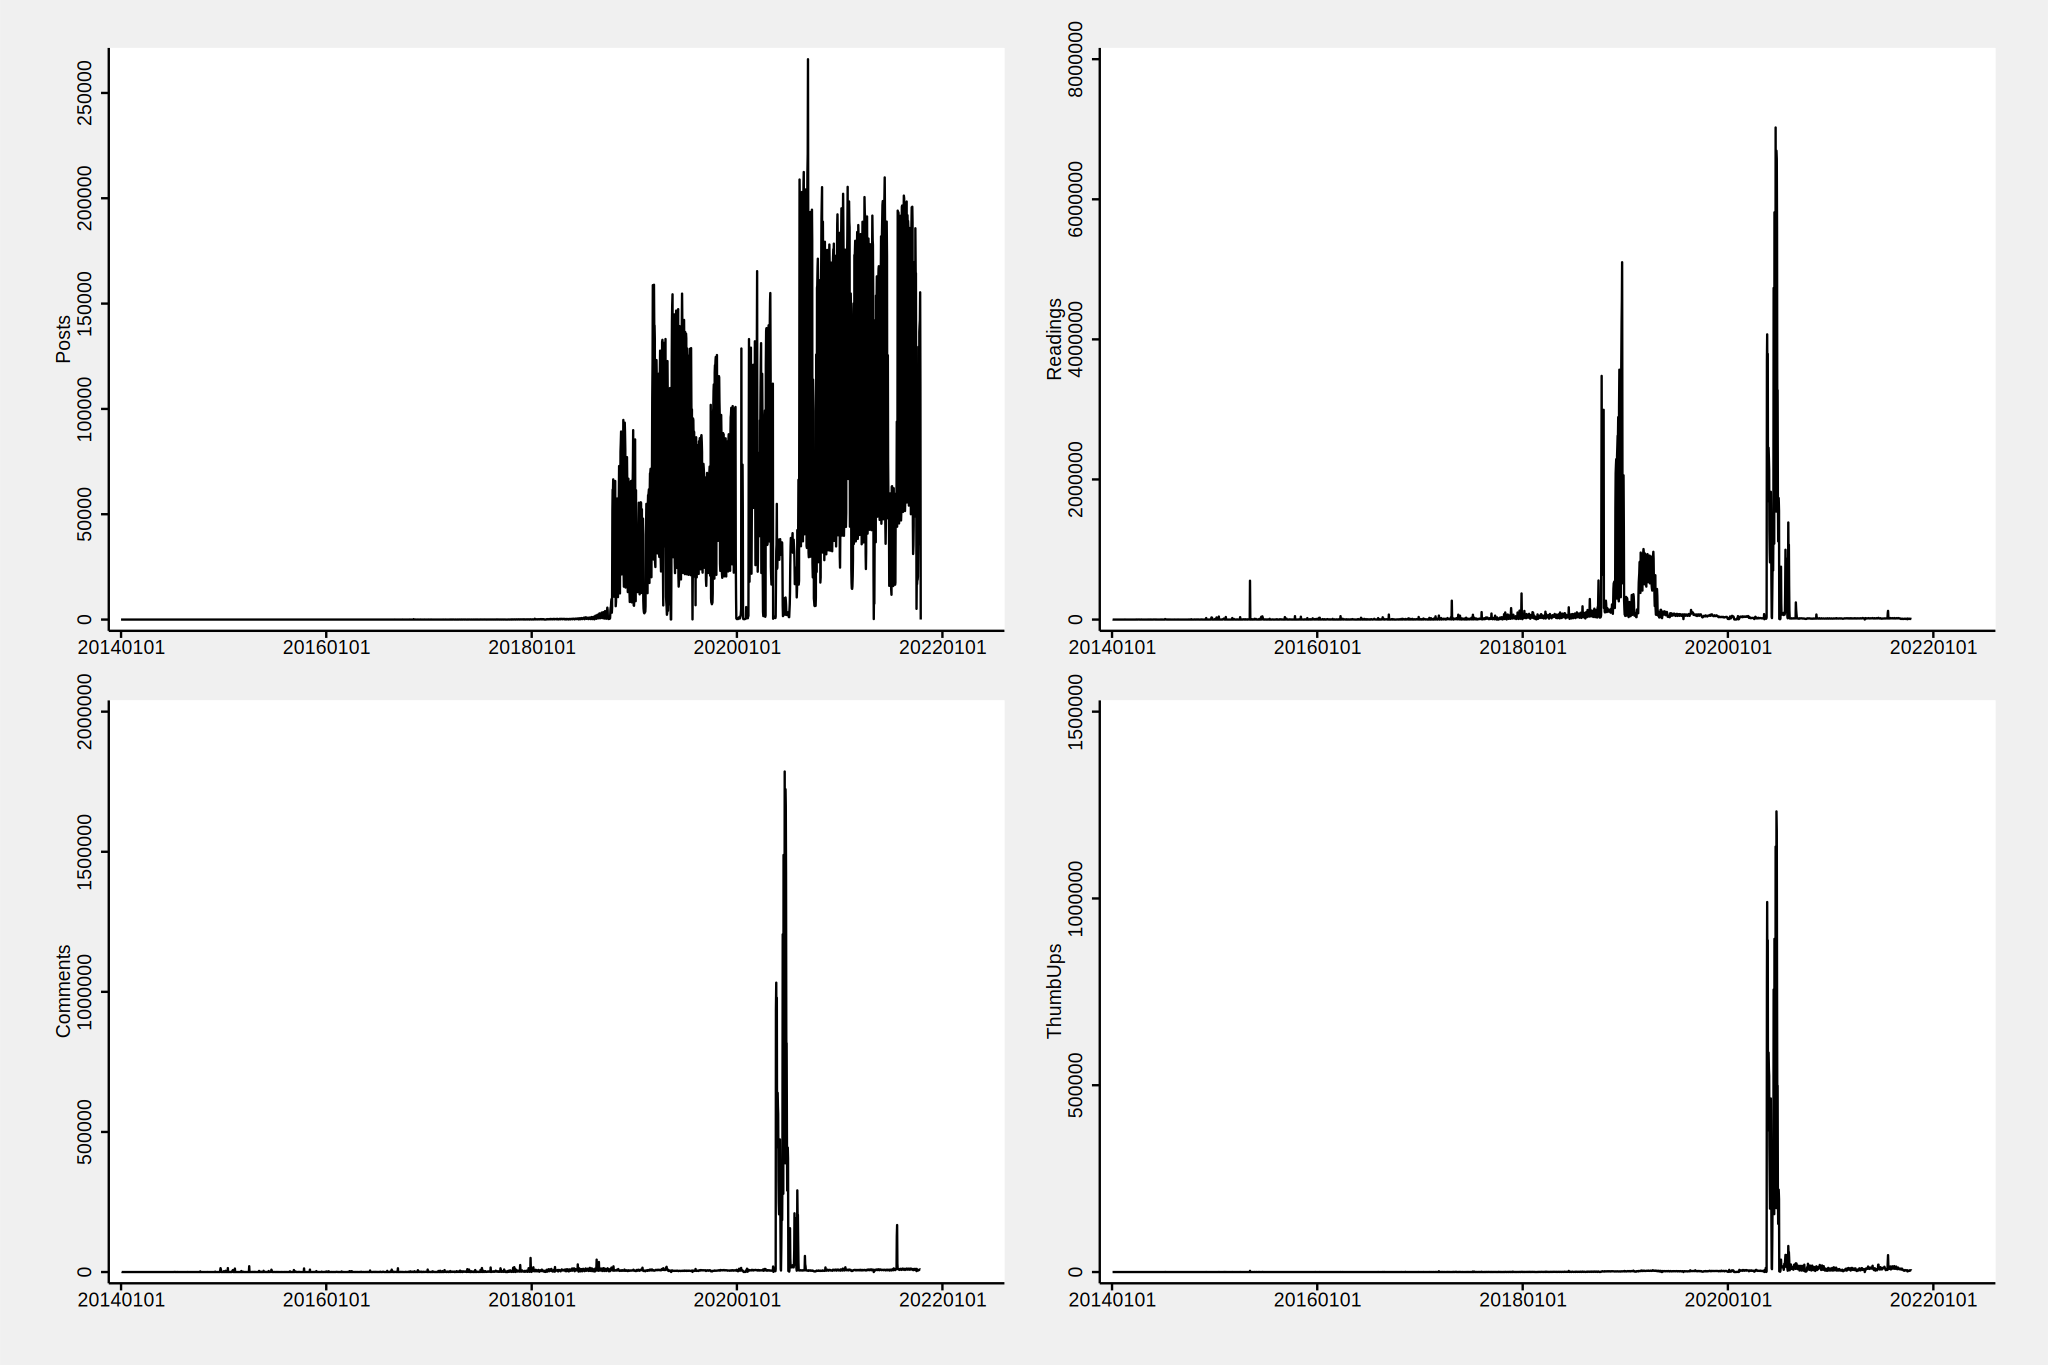

In [10]:
%%stata  -gw 12in -gh 8in
graph combine Posts Readings Comments ThumbUps , name(c1,replace) xcommon scale(0.5) scheme(sj)

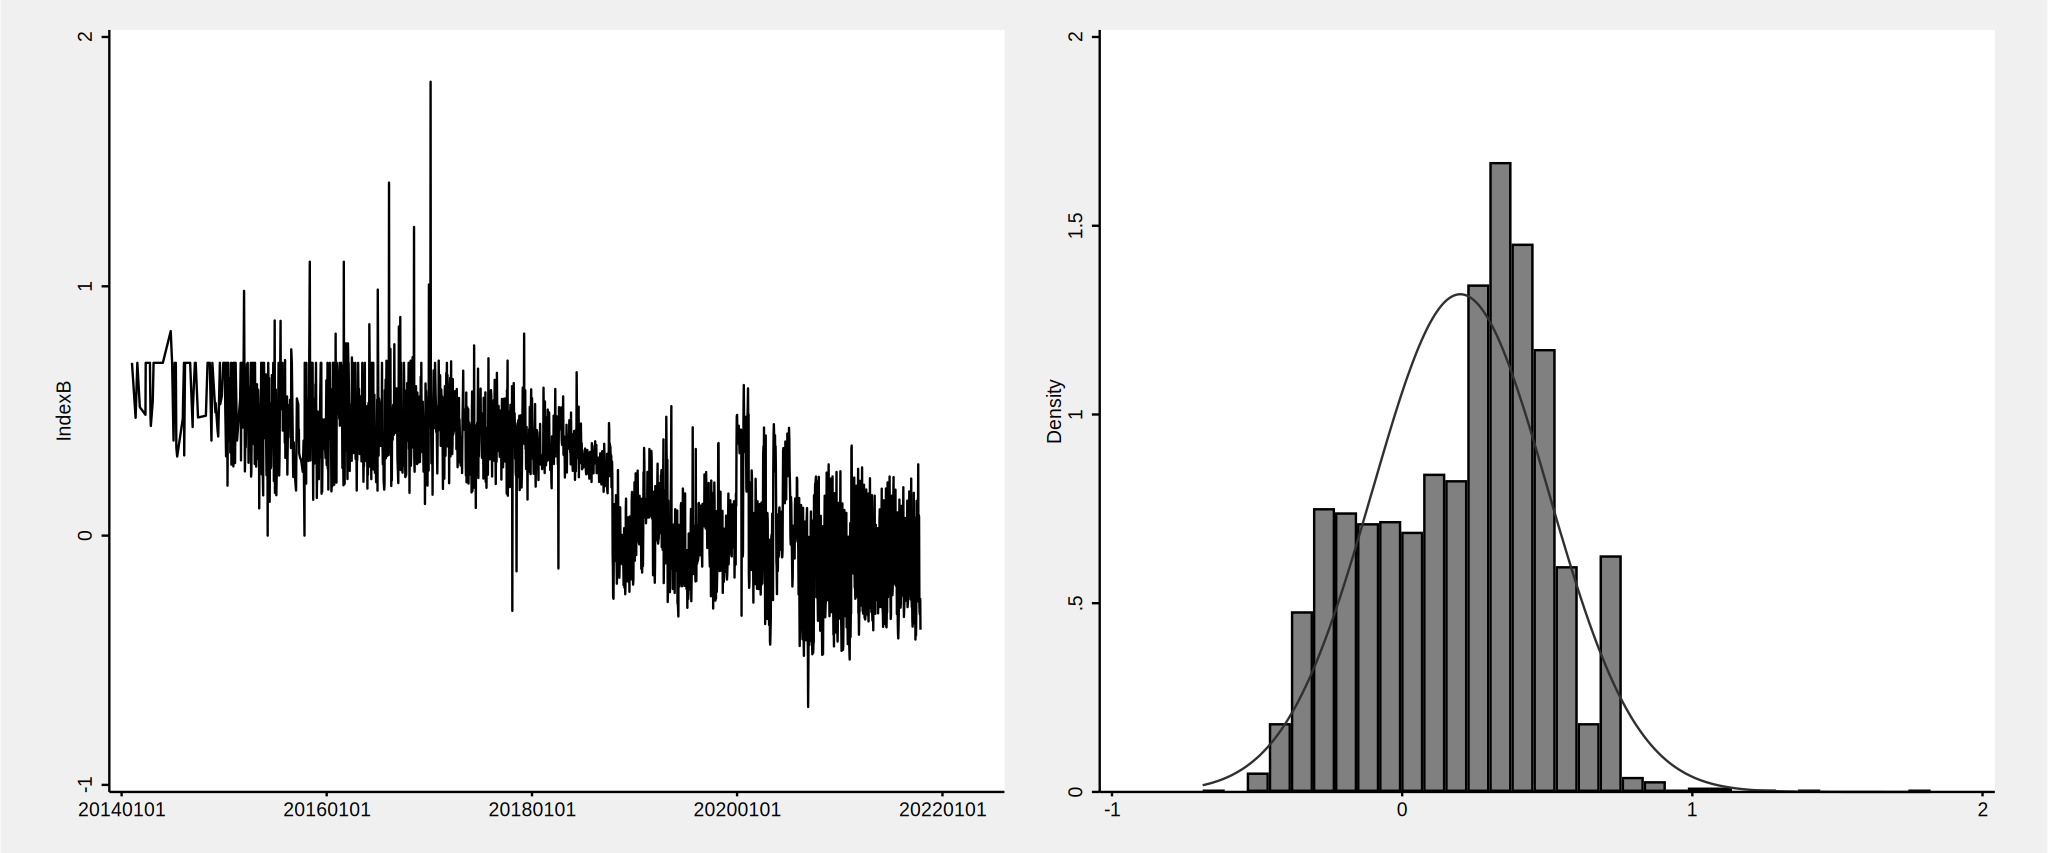

In [17]:
%%stata  -gw 12in -gh 5in
graph combine time_change dirtribution, name(c2,replace) scale(0.5)  scheme(sj)

## 3.媒体情绪对投资者情绪的影响

### 线性回归分析

In [12]:
%%stata -d df_ols -force
//清除
est clear

//设定时间序列
ge time=_n
tsset time

//缩尾
winsor2 IndexA, cut(1 99)
winsor2 IndexB, cut(1 99)

//外生变量
ge dt = date(trade_date, "YMD")
format dt %tdCCYYNNDD
ge year=year(dt)

//变量对数处理
ge lnPosts=ln(Posts)
ge lnReadings=ln(Readings)
ge lnComments=ln(Comments)
ge lnThumbUps=ln(ThumbUps)

//图像情绪回归
rename(img_neg) (media_neg)
eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
rename(media_neg) (img_neg)

//文本情绪回归
rename(tex_neg) (media_neg)
eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnThumbUps i.year,r
rename(media_neg) (tex_neg)

//增加固定效应
estadd local Year "Yes" : *

//输出结果
esttab using Investor-Sentiment/outputs/media_to_investor ,r type ///
keep(L.*) ///
star(* 0.1 ** 0.05 *** 0.01) ///
stats( Year r2_a N, fmt(%3s %12.2f %12.0f)) ///
title("Table MediaSent to InvestorSent") mtitle("ImgNeg" "TextNeg") ///
nogaps  b(%12.4f)


. //清除
. est clear

. 
. //设定时间序列
. ge time=_n

. tsset time

Time variable: time, 1 to 3074
        Delta: 1 unit

. 
. //缩尾
. winsor2 IndexA, cut(1 99)

. winsor2 IndexB, cut(1 99)

. 
. //外生变量
. ge dt = date(trade_date, "YMD")

. format dt %tdCCYYNNDD

. ge year=year(dt)

. 
. //变量对数处理
. ge lnPosts=ln(Posts)
(488 missing values generated)

. ge lnReadings=ln(Readings)
(488 missing values generated)

. ge lnComments=ln(Comments)
(492 missing values generated)

. ge lnThumbUps=ln(ThumbUps)
(764 missing values generated)

. 
. //图像情绪回归
. rename(img_neg) (media_neg)

. eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est1 stored)

. rename(media_neg) (img_neg)

. 
. //文本情绪回归
. rename(tex_neg) (media_neg)

. eststo: qui reg IndexB L.media_neg L.lnPosts L.lnReadings L.lnComments L.lnTh
> umbUps i.year,r
(est2 stored)

. rename(media_neg) (tex_neg)

. 
. //增加固定效应
. estadd local Year "Yes" : *

. 
. //输出结果
. esttab using Investor-Sentiment/ou